In [282]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

In [283]:
#Separating Training and Testing data
trainData=[]
trainClass=[]
testData=[]
testClass=[]

#image - 112*92 = 10304(mn)
for i in range(1,41):
    for j in range(1,11):
        image=cv2.imread("face_data\\s"+str(i)+"\\"+str(j)+".pgm",0)
        image=np.ravel(image).astype(np.int64)
        if(j>6):
            testData.append(image)
            testClass.append(i)
        else:
            trainData.append(image)
            trainClass.append(i)

In [284]:

trainimgs=np.array(trainData).T
testimgs=np.array(testData).T

trainClass=np.array(trainClass)
testClass=np.array(testClass)

In [285]:
def mean_zero_face(data):   #Mean Zero Face Data
    Mean=np.mean(data, axis = 1)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data[i][j] = data[i][j] - Mean[i]
    return data 
    

In [286]:
train_0=mean_zero_face(trainimgs)
test_0=mean_zero_face(testimgs)

In [287]:
#Function to calculate Eucliedean distance
def euclidean(a,b):
    d=(a-b)**2
    s=np.sum(d)
    return s**0.5

In [288]:
def PCA(train_0,k):
    cov = np.dot(train_0.T, train_0) #Covariance matrix
    eigenValue,eigenVector=np.linalg.eig(cov) #Finding eigen values and eigen Vectors for PCA
    sort_eigenValue=np.argsort(eigenValue) #Sorting eigen Values
    sort_eigenValue=sort_eigenValue[::-1]
    K_Vector=[]
    for i in range(k):
        K_Vector.append(eigenVector[sort_eigenValue[i]]) #Getting K best Directions
    K_Vector=np.array(K_Vector).T 
    eigen_faces=np.dot(K_Vector.T,train_0.T) #Generating eigen faces
    signature=np.dot(eigen_faces,train_0) #Generating Signature for all faces
    
    return [eigen_faces,signature]

In [289]:
#PCA
acc_pca=[]
K=[]
for k in range(1,150):
    eigen_faces,signature=PCA(train_0,k)
    
    #testing
    test_samples=np.dot(eigen_faces,test_0)
    
    success=0
    for i in range(160) : 
        test_img=test_samples[:,i]
        
        #Finding the class of the test image by calculating euclidean distance from a test image to all train images
        minDist=0
        ind=0
        for j in range(240):
            train_img=signature[:,j]
            dist=euclidean(test_img,train_img) 
            
            if minDist==0 :
                minDist=dist
                ind=j
            else :
                if dist<minDist:
                    minDist=dist
                    ind=j
                    
        if trainClass[ind]==testClass[i]:
            success=success+1
            
    K.append(k)
    acc_pca.append(success*100/testimgs.shape[1])

In [290]:
K1=240
eigen_faces,signature=PCA(train_0,K1) # Selected 240 features from PCA 

In [303]:
#Mean calculation
noc=int(signature.shape[1]/6) #no.of classes
MOC=np.mean(signature,axis=1) #Overall ean of all classes
MOC=MOC.reshape(len(MOC),1) 

In [304]:
#Within Class Scatter Matrix
SW = np.zeros([K1,K1])
for i in range(noc):
    j=i*6
    V=signature[:,j:j+6]
    class_mean=np.mean(V,axis = 1)
    class_mean=class_mean.reshape(len(class_mean),1)
    Mean= np.repeat(class_mean,6,axis = 1)
    x=V-Mean
    SW = SW + np.dot(x,x.T) #Adding variance of class to SW
    
#Between Class Scatter Matrix
SB = np.zeros([K1,K1])
for i in range(noc):
    V = signature[:,i:i+6]
    class_mean=np.mean(V,axis = 1)
    class_mean=class_mean.reshape(len(class_mean),1)
    x=class_mean-MOC
    SB = SB  + np.dot(x,class_mean.T)

In [305]:
J = np.dot(np.linalg.pinv(SW), SB) #Finding Criterion function
eigenValue,eigenVector=np.linalg.eig(J) #Finding eigen values and eigen Vectors for LDA
sort_eigenValue=np.argsort(eigenValue) #Sorting eigen Values
sort_eigenValue=sort_eigenValue[::-1]

In [306]:
#LDA
acc_lda=[]
M=[]
for m in range(1,150):
    M_Vector=[]
    for i in range(m):
        M_Vector.append(eigenVector[sort_eigenValue[i]])  #Getting m best Directions
    M_Vector=np.array(M_Vector).T 
    
    FF= np.dot(M_Vector.T, signature) #Generating Fisher Faces
    PEF= np.dot(eigen_faces,test_0)  #Generating Projected Eigen faces
    PFT = np.dot(M_Vector.T,PEF) #Generating projected fisher test images
    
    success=0
    for i in range(160) : 
        test_img=PFT[:,i]
        
        #Finding the class of the test image by calculating euclidean distance from a test image to all train images
        minDist=0
        ind=0
        for j in range(240):
            train_img=FF[:,j]
            dist=euclidean(test_img,train_img) 
            
            if minDist==0 :
                minDist=dist
                ind=j
            else :
                if dist<minDist:
                    minDist=dist
                    ind=j
                    
        if trainClass[ind] == testClass[i]:
            success=success+1
            
    M.append(m)
    acc_lda.append(success*100/testimgs.shape[1])

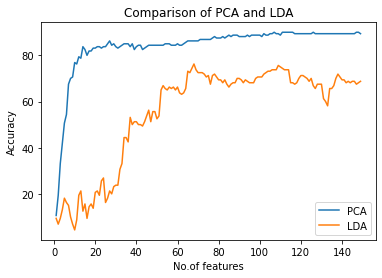

In [307]:
plt.plot(K,acc_pca)
plt.plot(M,acc_lda)
plt.title('Comparison of PCA and LDA')
plt.xlabel("No.of features")
plt.ylabel("Accuracy")
plt.legend(["PCA","LDA"])
plt.show()

In [314]:
print("Accuracy of PCA-",max(acc_pca),"% at K =",acc_pca.index(max(acc_pca)))
print("Accuracy of LDA-",max(acc_lda),"% at M =",acc_lda.index(max(acc_lda)))
if(max(acc_pca)>max(acc_lda)):
    print("PCA suits better for face recognition than LDA")
else:
    print("LDA suits better for face recognition than PCA")

Accuracy of PCA- 90.0 % at K = 106
Accuracy of LDA- 76.25 % at M = 67
PCA suits better for face recognition than LDA
